# intro

The purpose of this notebook will be to create a concise, 5-subplot figure with:
- map overview (surface OHC trend, sea ice edge in March for certain averages, mark key gateways, overlay ocean currents
- time series, inflow evolotion (advective heat transport through the BSO, mean temperature of inflow, other gate specific transports)
- gate cross sections (4 small subplots of temperature profile at the gates; outline AW)
- N/S cross section in the interior (density evolution, emphasize AW shoaling, warming, upward mixing; outline AW)
- time series AW thickness time series over the Barents Sea interior along with sea ice extent (sea ice extent anomaly or labeled)

In [1]:
# import packages and functions

# import packages and functions
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
from matplotlib.lines import Line2D

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from matplotlib.colors import ListedColormap, BoundaryNorm


# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import pandas as pd  # For rolling mean
from scipy.ndimage import binary_dilation
from matplotlib.lines import Line2D

%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [2]:
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2003,2018,1)

In [4]:
# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

In [5]:
# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan
hfC[hfC<1] = np.nan

In [6]:
# define the gateways
x_bso = gg['BarentsSeaOpening']["ix"]-1   # 0 
y_bso = gg['BarentsSeaOpening']["jy"]-1
x_bso[x_bso == 162] = 161

x_sfj = gg['Svalbard-FranzJosefIslands']["ix"]-1   # 1
y_sfj = gg['Svalbard-FranzJosefIslands']["jy"]-1
x_sfj,y_sfj = x_sfj[1:],y_sfj[1:]

x_fjnz = gg['FranzJosefIslands-NovayaZemlya']["ix"]-1  #2 
y_fjnz = gg['FranzJosefIslands-NovayaZemlya']["jy"]-1

x_nzru = np.full((5),37)
y_nzru = np.arange(460,465,1)

gates = np.full(mskBasin.shape,np.nan)
gates[y_bso,x_bso] = 1
gates[y_sfj,x_sfj] = 2
gates[y_fjnz,x_fjnz] = 3
gates[y_nzru,x_nzru] = 4

In [7]:
# also define the bear island trench
bso_depths = mygrid['Depth'][y_bso, x_bso]
valid_indices = bso_depths > 268

y_bit = y_bso[valid_indices]
x_bit = x_bso[valid_indices]
bit_mask = np.full(mskBasin.shape,np.nan)
bit_mask[y_bit,x_bit] = 1

In [8]:
# define the Barents Sea up to the NZRU opening
mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

for i,j in zip (idxs[0],idxs[1]):
    mymsk[i,j] = 1

# we have to add in until the edge of novaya zemlya
mymsk2 = get_aste_tracer(mymsk,nfx,nfy)[0]
mymsk2[:487,510:] = 1
mymsk2[:490,532:] = 1
mymsk = aste_tracer2compact(mymsk2,nfx,nfy)[0]

# remember to mask with land so we have the correct item
mymsk = mymsk * hfC[0]
mymsk[mymsk == 0] = np.nan

In [9]:
# do some sample cross sections
y_sample = np.arange(435,551,1)
x_sample = np.full(y_sample.shape,466)

x_cross = np.arange(430,505,1)
y_cross = np.full(x_cross.shape,494)

sample_cross = np.full((900,540),np.nan)
sample_cross[y_sample,x_sample]= 1
sample_cross[y_cross,x_cross]= 3
sample_cross = aste_tracer2compact(sample_cross,nfx,nfy)[0]

(400.0, 600.0)

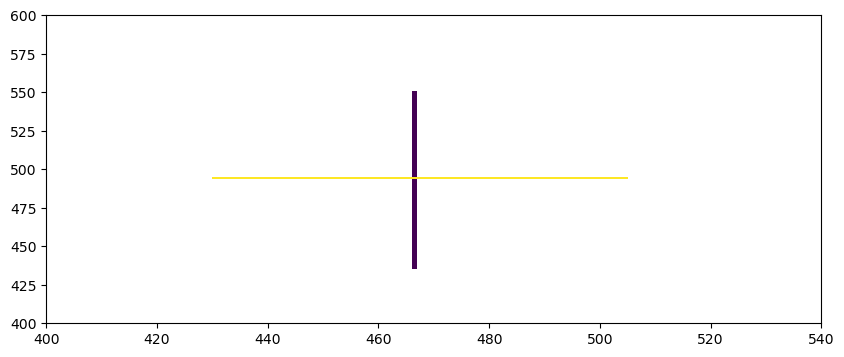

In [10]:
# plt.pcolormesh(land_data)
plt.pcolormesh(get_aste_tracer(sample_cross,nfx,nfy)[0])
plt.xlim(400,540)
plt.ylim(400,600)

In [11]:
tstart = 3

In [12]:
lon = get_aste_tracer(mygrid['XC'],nfx,nfy)[0]
lat = get_aste_tracer(mygrid['YC'],nfx,nfy)[0]

# B: time series inflow evolution

In [13]:
# gates and series
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations
choose_UV_bso = line_orientation(y_bso,x_bso)
choose_UV_sfj = line_orientation(y_sfj,x_sfj)
choose_UV_fjnz = line_orientation(y_fjnz,x_fjnz)
choose_UV_nzru = line_orientation(y_nzru,x_nzru)

choose_UV_bso3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_bso,x_bso):
    choose_UV_bso3d[:,i,j] = np.full(nz,choose_UV_bso[idx])
    idx += 1

choose_UV_sfj3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_sfj,x_sfj):
    choose_UV_sfj3d[:,i,j] = np.full(nz,choose_UV_sfj[idx])
    idx += 1

choose_UV_fjnz3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_fjnz,x_fjnz):
    choose_UV_fjnz3d[:,i,j] = np.full(nz,choose_UV_fjnz[idx])
    idx += 1

choose_UV_nzru3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_nzru,x_nzru):
    choose_UV_nzru3d[:,i,j] = np.full(nz,choose_UV_nzru[idx])
    idx += 1

In [15]:
tstart=3

In [16]:
# Define dimensions
num_years = len(allyears[tstart:])  # Number of years
gate_labels = ["BSO", "SFJ", "FJNZ","NZRU"]

# Get indices for each gate dynamically
gate_indices = {gate: np.where(gates == label) for gate, label in zip(gate_labels, [1, 2, 3, 4])}

# Initialize dictionaries with variable-length arrays for each gate
theta_timeseries = {gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()}
salt_timeseries = {gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()}

iy = 0  # Counter for year index

for year in allyears[tstart:]:
    print(f"Processing year: {year}")

    # Get time steps for this year
    years = np.array([str(year)])
    times = {year: np.arange(1, 13, 1)}  # All 12 months
    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)

    # Initialize arrays to hold full-year data
    THETA_all = np.full((len(tsstr), nz, ny, nx), np.nan)
    SALT_all = np.full((len(tsstr), nz, ny, nx), np.nan)

    # Loop over all time steps
    for i in range(len(tsstr)):
        file_name = "state_3d_set1"
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        recs = [np.where(fldlist == var)[0][0] for var in ["THETA", "SALT"]]

        read = [int(tsstr[i])]
        THETAi, _, _ = rdmds(os.path.join(dirState, file_name), read, returnmeta=True, rec=recs[0])
        SALTi, _, _ = rdmds(os.path.join(dirState, file_name), read, returnmeta=True, rec=recs[1])

        THETA_all[i, :, :, :] = np.reshape(THETAi, (nz, ny, nx))
        SALT_all[i, :, :, :] = np.reshape(SALTi, (nz, ny, nx))

    

    for gate in gate_labels:
        y_idx, x_idx = gate_indices[gate]  # Get dynamic indices

        # Compute annual averages for each gate
        RAC_gate = np.tile(mygrid['RAC'][np.newaxis,:,:],(nz,1,1))[:,y_idx, x_idx]  # shape (npoints,)
        DRF_gate = DRF3d[:,y_idx,x_idx]
        hfC_gate = hfC[:,y_idx,x_idx]
        volume_gate = RAC_gate * DRF_gate * hfC_gate

        #print(y_idx)
        for depth in range(nz):

            theta_timeseries[gate][iy, :, depth, :] = THETA_all[:, depth, y_idx, x_idx] * volume_gate[depth] 
            salt_timeseries[gate][iy, :, depth, :] = SALT_all[:, depth, y_idx, x_idx] * volume_gate[depth] 

    iy += 1  # Move to the next year


Processing year: 2006
Processing year: 2007
Processing year: 2008
Processing year: 2009
Processing year: 2010
Processing year: 2011
Processing year: 2012
Processing year: 2013
Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017


In [17]:
# Compute distances dynamically for each gate
gate_distances = {}

for gate, (x_gate, y_gate, choose_UV_gate) in zip(gate_labels, [(x_bso, y_bso, choose_UV_bso), 
                                                                (x_sfj, y_sfj, choose_UV_sfj), 
                                                                (x_fjnz, y_fjnz, choose_UV_fjnz),
                                                                (x_nzru, y_nzru, choose_UV_nzru)]):
    distance = np.array([])
    for i in range(len(x_gate)):
        thisy = y_gate[i]
        thisx = x_gate[i]
        this_choose = choose_UV_gate[i]
        
        if this_choose == 'H':
            distance = np.append(distance, mygrid['DYG'][thisy, thisx])
        else:
            distance = np.append(distance, mygrid['DXG'][thisy, thisx])

    gate_distances[gate] = np.cumsum(distance / 1000)  # Convert to km

# Compute depth array
depths = np.cumsum(-mygrid["DRF"])  # Convert to depth in meters

In [18]:
# Define dimensions
num_years = len(allyears[tstart:])  # Number of years
gate_labels = ["BSO", "SFJ", "FJNZ", "NZRU"]

# Get indices for each gate dynamically
gate_indices = {gate: np.where(gates == label) for gate, label in zip(gate_labels, [1, 2, 3, 4])}

# Selection dictionary for horizontal (ADVx_TH) or vertical (ADVy_TH) transport
choose_UV = {"BSO": choose_UV_bso3d, "SFJ": choose_UV_sfj3d, "FJNZ": choose_UV_fjnz3d, "NZRU": choose_UV_nzru3d}

# Initialize dictionary to store heat transport for each gate
heat_transport_timeseries = {
    gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()
}

iy = 0  # Counter for year index

for year in allyears[tstart:]:
    print(f"Processing year: {year}")

    # Get time steps for this year
    years = np.array([str(year)])
    times = {year: np.arange(1, 13, 1)}  # All 12 months
    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)

    # Initialize arrays to hold full-year data
    ADVx_TH_all = np.full((len(tsstr), nz, ny, nx), np.nan)
    ADVy_TH_all = np.full((len(tsstr), nz, ny, nx), np.nan)

    # Loop over all time steps
    for i in range(len(tsstr)):
        file_name = "budg3d_hflux_set2"
        meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
        recs = [np.where(fldlist == var)[0][0] for var in ["ADVx_TH", "ADVy_TH"]]

        read = [int(tsstr[i])]
        ADVx_THi, _, _ = rdmds(os.path.join(dirIn, file_name), read, returnmeta=True, rec=recs[0])
        ADVy_THi, _, _ = rdmds(os.path.join(dirIn, file_name), read, returnmeta=True, rec=recs[1])

        ADVx_TH_all[i, :, :, :] = np.reshape(ADVx_THi, (nz, ny, nx))
        ADVy_TH_all[i, :, :, :] = np.reshape(ADVy_THi, (nz, ny, nx))

    # Compute annual averages for each gate
    for gate in gate_labels:
        y_idx, x_idx = gate_indices[gate]  # Get dynamic indices
        UV_selection = choose_UV[gate]  # Determine whether to use H (ADVx_TH) or V (ADVy_TH)
        
        for depth in range(nz):
            advx_seasonal = myparms["rcp"] * ADVx_TH_all[:, depth, y_idx, x_idx]
            advy_seasonal = myparms["rcp"] * ADVy_TH_all[:, depth, y_idx, x_idx]
            
            # Use np.where() for per-gridpoint selection
            if gate == "BSO":
                adv_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", advx_seasonal, -advy_seasonal)
            elif gate == "SFJ":
                adv_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", -advx_seasonal, -advy_seasonal)
            else:
                adv_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", -advx_seasonal, -advy_seasonal)

            heat_transport_timeseries[gate][iy, :, depth, :] = adv_selected


    iy += 1  # Move to the next year

Processing year: 2006
Processing year: 2007
Processing year: 2008
Processing year: 2009
Processing year: 2010
Processing year: 2011
Processing year: 2012
Processing year: 2013
Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017


In [19]:
# Define dimensions
num_years = len(allyears[tstart:])  # Number of years
gate_labels = ["BSO", "SFJ", "FJNZ", "NZRU"]

# Get indices for each gate dynamically
gate_indices = {gate: np.where(gates == label) for gate, label in zip(gate_labels, [1, 2, 3, 4])}

# Selection dictionary for horizontal (ADVx_TH) or vertical (ADVy_TH) transport
choose_UV = {"BSO": choose_UV_bso3d, "SFJ": choose_UV_sfj3d, "FJNZ": choose_UV_fjnz3d, "NZRU": choose_UV_nzru3d}

# Initialize dictionary to store heat transport for each gate
vel_timeseries = {
    gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()
}

iy = 0  # Counter for year index

for year in allyears[tstart:]:
    print(f"Processing year: {year}")

    # Get time steps for this year
    years = np.array([str(year)])
    times = {year: np.arange(1, 13, 1)}  # All 12 months
    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)

    # Initialize arrays to hold full-year data
    UVELMASS_all = np.full((len(tsstr), nz, ny, nx), np.nan)
    VVELMASS_all = np.full((len(tsstr), nz, ny, nx), np.nan)

    # Loop over all time steps
    for i in range(len(tsstr)):
        file_name = "trsp_3d_set1"
        meta_trsp_3d_set1 = parsemeta(dirtrsp + file_name + "." + (tsstr[0]) + ".meta")
        fldlist = np.array(meta_trsp_3d_set1["fldList"])
        recs = [np.where(fldlist == var)[0][0] for var in ["UVELMASS", "VVELMASS"]]

        read = [int(tsstr[i])]
        UVELMASSi, _, _ = rdmds(os.path.join(dirtrsp, file_name), read, returnmeta=True, rec=recs[0])
        VVELMASSi, _, _ = rdmds(os.path.join(dirtrsp, file_name), read, returnmeta=True, rec=recs[1])

        UVELMASS_all[i, :, :, :] = np.reshape(UVELMASSi, (nz, ny, nx))
        VVELMASS_all[i, :, :, :] = np.reshape(VVELMASSi, (nz, ny, nx))


    # Compute annual averages for each gate
    for gate in gate_labels:
        y_idx, x_idx = gate_indices[gate]  # Get dynamic indices
        UV_selection = choose_UV[gate]  # Determine whether to use H (ADVx_TH) or V (ADVy_TH)
        
        for depth in range(nz):
            u_seasonal = UVELMASS_all[:, depth, y_idx, x_idx]
            v_seasonal = VVELMASS_all[:, depth, y_idx, x_idx]
            
            # Use np.where() for per-gridpoint selection
            if gate == "BSO":
                vel_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", u_seasonal, -v_seasonal)
            elif gate == "SFJ":
                vel_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", -u_seasonal, -v_seasonal)
            else:
                vel_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", -u_seasonal, -v_seasonal)

            vel_timeseries[gate][iy, :, depth, :] = vel_selected


    iy += 1  # Move to the next year

Processing year: 2006
Processing year: 2007
Processing year: 2008
Processing year: 2009
Processing year: 2010
Processing year: 2011
Processing year: 2012
Processing year: 2013
Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017


In [ ]:
# plot just the BSO / Bear Island Trench in and outflow



In [20]:
# fig, axes = plt.subplots(4, 1, figsize=(8, 12), sharex=True)
# nyears = 15

# xtick_positions = np.arange(0, nyears*12, 12)
# xtick_labels = np.arange(2003, 2018)
# time = np.arange(0, nyears*12)
# window_size = 12  # months

# gates_names = np.array(['BSO', 'SFJ', 'FJNZ', 'NZRU'])
# choose_UV_dict = {
#     'BSO': choose_UV_bso3d,
#     'SFJ': choose_UV_sfj3d,
#     'FJNZ': choose_UV_fjnz3d,
#     'NZRU': choose_UV_nzru3d
# }

# for i, gate in enumerate(gates_names):
#     ax1 = axes[i]
#     vel = vel_timeseries[gate]  # shape: (years, months, depth, gatepoints)
#     theta_volume = theta_timeseries[gate]  # THETA * volume
#     Q = heat_transport_timeseries[gate] * myparms['rcp'] * 1e-6  # MJ/s

#     # Recreate volume mask (same shape as theta_volume)
#     DRF = mygrid['DRF']
#     RAC_gate = mygrid['RAC'][gate_indices[gate]]  # shape: (gatepoints,)
#     volume_mask = np.zeros_like(theta_volume)

#     for k in range(nz):
#         volume_mask[:, :, k, :] = DRF[k] * RAC_gate[np.newaxis, :]  # broadcast - this is also wrong because RAC is horizontal area

#     # Create inflow/outflow masks
#     inflow_mask = vel > 0
#     outflow_mask = vel < 0

#     # -------- Volume-weighted Temperature --------
#     T_inflow = np.nansum(theta_volume * inflow_mask, axis=(2, 3)) / np.nansum(volume_mask * inflow_mask, axis=(2, 3))
#     T_outflow = np.nansum(theta_volume * outflow_mask, axis=(2, 3)) / np.nansum(volume_mask * outflow_mask, axis=(2, 3))

#     # -------- Heat Transport --------
#     Q_inflow = np.nansum(Q * inflow_mask, axis=(2, 3))
#     Q_outflow = np.nansum(Q * outflow_mask, axis=(2, 3))

#     # -------- Smoothing --------
#     heat_in_smooth = pd.Series(Q_inflow.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()
#     heat_out_smooth = pd.Series(Q_outflow.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()
#     temp_in_smooth = pd.Series(T_inflow.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()
#     temp_out_smooth = pd.Series(T_outflow.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()

#     # -------- Plotting --------
#     ax1.plot(time, heat_in_smooth, color="darkred", label="Inflow OHT")
#     ax1.plot(time, heat_out_smooth, color="firebrick", linestyle="--", label="Outflow OHT")
#     ax1.set_ylabel("OHT (MJ/s)", color="darkred")
#     ax1.tick_params(axis='y', labelcolor="darkred")
#     ax1.set_title(f"{gate}")
#     ax1.set_xticks(xtick_positions)
#     ax1.set_xticklabels(xtick_labels, rotation=45)
#     ax1.grid(alpha=0.2)

#     # Twin axis for temperature
#     ax2 = ax1.twinx()
#     ax2.plot(time, temp_in_smooth, color="royalblue", label="Inflow Temp")
#     ax2.plot(time, temp_out_smooth, color="steelblue", linestyle="--", label="Outflow Temp")
#     ax2.set_ylabel("Temp (°C)", color="royalblue")
#     ax2.tick_params(axis='y', labelcolor="royalblue")

#     if i == 0:
#         lines1, labels1 = ax1.get_legend_handles_labels()
#         lines2, labels2 = ax2.get_legend_handles_labels()
#         ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower right")

# fig.supxlabel("Time")
# fig.suptitle("Inflow and Outflow Heat Transport & Volume-Weighted Temperature", fontsize=14)
# plt.tight_layout()
# # plt.savefig("inout_timeseries_weighted_temp.png", dpi=300)
# plt.show()


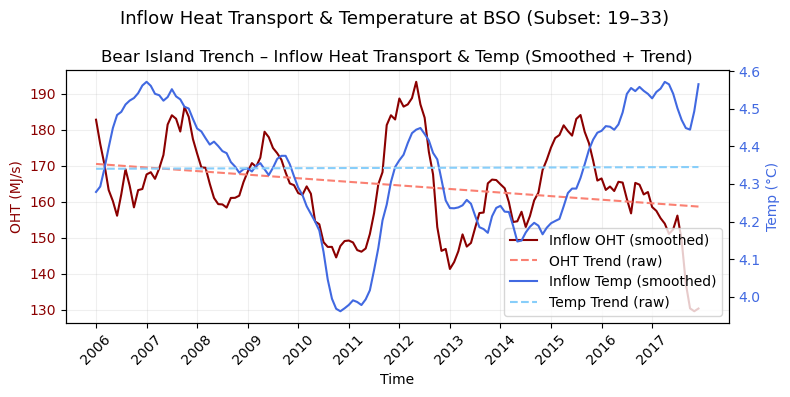

In [33]:
fig, ax1 = plt.subplots(figsize=(8, 4))

xtick_positions = np.arange(0, 12*12, 12)
xtick_labels = np.arange(2006, 2018)
time = np.arange(0, 12*12)
window_size = 12  # months

gate = 'BSO'
gate_slice = slice(19, 34)

# Load data
vel = vel_timeseries[gate][:, :, :, gate_slice]
theta_volume = theta_timeseries[gate][:, :, :, gate_slice]
Q = heat_transport_timeseries[gate][:, :, :, gate_slice] * myparms['rcp'] * 1e-12 * 1e-6  # Sv.degC * 1e-12

# Volume mask
DRF = mygrid['DRF']
RAC_gate = mygrid['RAC'][gate_indices[gate]][gate_slice]
volume_mask = np.zeros_like(theta_volume)
for k in range(nz):
    volume_mask[:, :, k, :] = DRF[k] * RAC_gate[np.newaxis, :]

# Inflow mask
inflow_mask = vel > 0

# Volume-weighted inflow θ and heat transport (raw)
T_inflow = np.nansum(theta_volume * inflow_mask, axis=(2, 3)) / np.nansum(volume_mask * inflow_mask, axis=(2, 3))
Q_inflow = np.nansum(Q * inflow_mask, axis=(2, 3))

# Flatten for plotting and smooth
T_inflow_flat = T_inflow.flatten()
Q_inflow_flat = Q_inflow.flatten()

temp_in_smooth = pd.Series(T_inflow_flat).rolling(window=window_size, center=True, min_periods=1).mean()
heat_in_smooth = pd.Series(Q_inflow_flat).rolling(window=window_size, center=True, min_periods=1).mean()

# Plot smoothed curves
ax1.plot(time, heat_in_smooth, color="darkred", label="Inflow OHT (smoothed)")
ax1.set_ylabel("OHT (MJ/s)", color="darkred")
ax1.tick_params(axis='y', labelcolor="darkred")
ax1.set_title("Bear Island Trench – Inflow Heat Transport & Temp (Smoothed + Trend)")
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, rotation=45)
ax1.grid(alpha=0.2)

# Linear trend from raw Q
coef_q = np.polyfit(time, Q_inflow_flat, 1)
trend_q = np.poly1d(coef_q)(time)
ax1.plot(time, trend_q, color="salmon", linestyle="--", label="OHT Trend (raw)")

# Temperature on twin axis
ax2 = ax1.twinx()
ax2.plot(time, temp_in_smooth, color="royalblue", label="Inflow Temp (smoothed)")
ax2.set_ylabel("Temp (°C)", color="royalblue")
ax2.tick_params(axis='y', labelcolor="royalblue")

# Linear trend from raw T
coef_t = np.polyfit(time, T_inflow_flat, 1)
trend_t = np.poly1d(coef_t)(time)
ax2.plot(time, trend_t, color="lightskyblue", linestyle="--", label="Temp Trend (raw)")

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower right")

# Layout
ax1.set_xlabel("Time")
plt.suptitle("Inflow Heat Transport & Temperature at BSO (Subset: 19–33)", fontsize=13)
plt.tight_layout()
# plt.savefig("figs/BSO_subset_19_34_smoothed_trends.png", dpi=300)
plt.show()


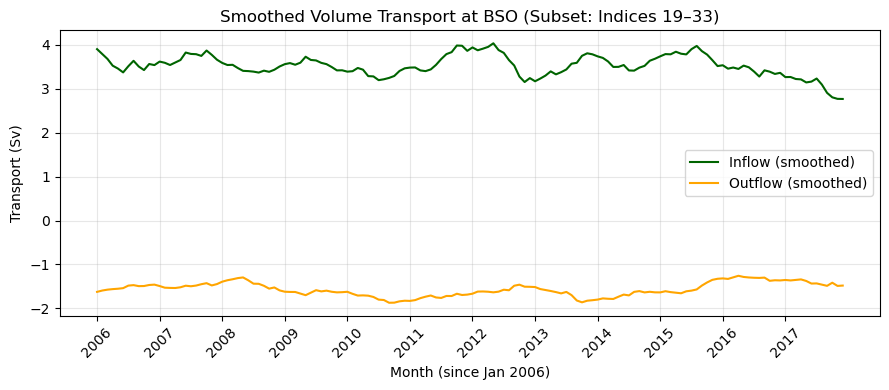

In [36]:
# Define selected indices
ysel = gate_indices['BSO'][0]#[19:34]
xsel = gate_indices['BSO'][1]#[19:34]
nyears = 12

# Prepare area array
area = np.zeros((nz, len(ysel)))
for k in range(nz):
    for i in range(len(ysel)):
        y = ysel[i]
        x = xsel[i]
        if choose_UV_bso3d[k, y, x] == "H":
            area[k, i] = mygrid['DRF'][k] * mygrid['DYG'][y, x]
        else:  # assume 'V'
            area[k, i] = mygrid['DRF'][k] * mygrid['DXG'][y, x]

# Read velocities
vel = vel_timeseries['BSO']#[:, :, :, 19:34]

# Multiply and sum properly
volume_transport_in = np.nansum(vel * (vel > 0) * area[None, None, :, :], axis=(2, 3))
volume_transport_out = np.nansum(vel * (vel < 0) * area[None, None, :, :], axis=(2, 3))

# Flatten and smooth
time = np.arange(0, nyears * 12)
window_size = 12

volume_transport_in_flat = volume_transport_in.flatten()
volume_transport_out_flat = volume_transport_out.flatten()

volume_in_smooth_test = pd.Series(volume_transport_in_flat).rolling(window=window_size, center=True, min_periods=1).mean()
volume_in_smooth = pd.Series(volume_transport_in_flat).rolling(window=window_size, center=True, min_periods=1).mean() *1e-6
volume_out_smooth = pd.Series(volume_transport_out_flat).rolling(window=window_size, center=True, min_periods=1).mean() *1e-6

# also grab the ADV- and TH- calculated OHT to check this
# we can multiply volume_in_smooth with the TH timeseries to check this with the ADV one - should be about the same

# Plot
plt.figure(figsize=(9, 4))

ax = plt.subplot(111)
ax.plot(time, volume_in_smooth, label="Inflow (smoothed)", color="darkgreen")
ax.plot(time, volume_out_smooth, label="Outflow (smoothed)", color="orange")
ax.set_title("Smoothed Volume Transport at BSO (Subset: Indices 19–33)")
ax.set_ylabel("Transport (Sv)")
ax.set_xlabel("Month (since Jan 2006)")


ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45)
ax.grid(alpha=0.2)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

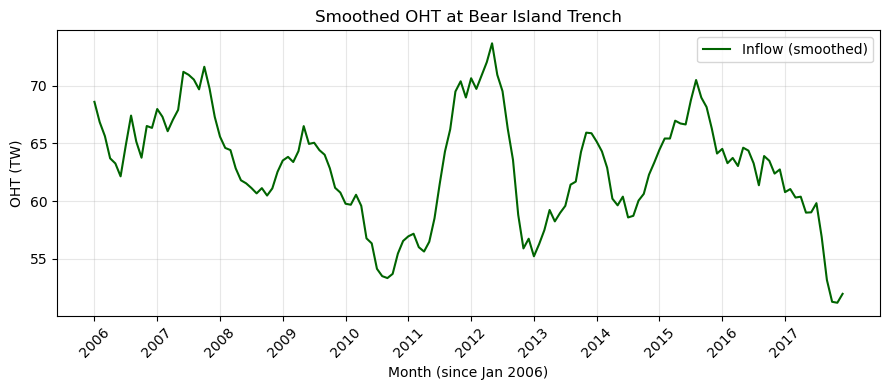

In [37]:
# Plot
plt.figure(figsize=(9, 4))

ax = plt.subplot(111)
ax.plot(time, volume_in_smooth * temp_in_smooth * myparms['rcp'] * 1e-6, label="Inflow (smoothed)", color="darkgreen")
ax.set_title("Smoothed OHT at Bear Island Trench")
ax.set_ylabel("OHT (TW)")
ax.set_xlabel("Month (since Jan 2006)")

ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45)
ax.grid(alpha=0.2)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

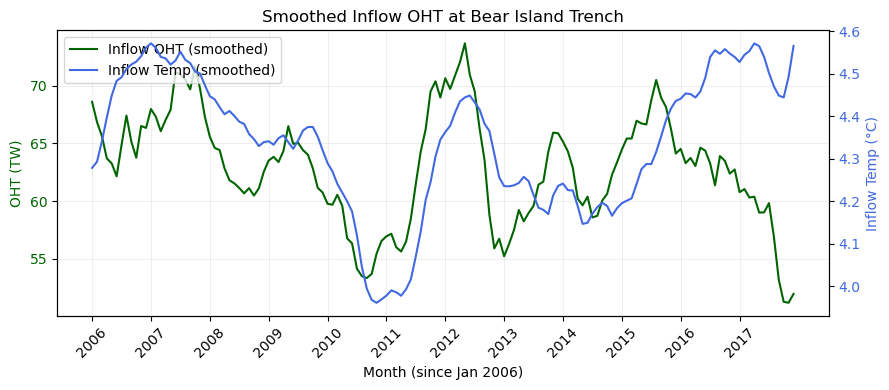

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assume these are already defined:
# time, volume_in_smooth, temp_in_smooth, myparms, xtick_positions, xtick_labels

# Plot
fig, ax1 = plt.subplots(figsize=(9, 4))

# Left y-axis: OHT = volume * temp * specific heat capacity (rcp), converted to TW
oht_smooth = volume_in_smooth * temp_in_smooth * myparms['rcp'] * 1e-6
ax1.plot(time, oht_smooth, label="Inflow OHT (smoothed)", color="darkgreen")
ax1.set_title("Smoothed Inflow OHT at Bear Island Trench")
ax1.set_ylabel("OHT (TW)", color="darkgreen")
ax1.set_xlabel("Month (since Jan 2006)")
ax1.tick_params(axis='y', labelcolor="darkgreen")
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, rotation=45)
ax1.grid(alpha=0.2)

# Right y-axis: inflow temperature
ax2 = ax1.twinx()
ax2.plot(time, temp_in_smooth, color="royalblue", label="Inflow Temp (smoothed)")
ax2.set_ylabel("Inflow Temp (°C)", color="royalblue")
ax2.tick_params(axis='y', labelcolor="royalblue")

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.tight_layout()
plt.show()

Processing BSO...


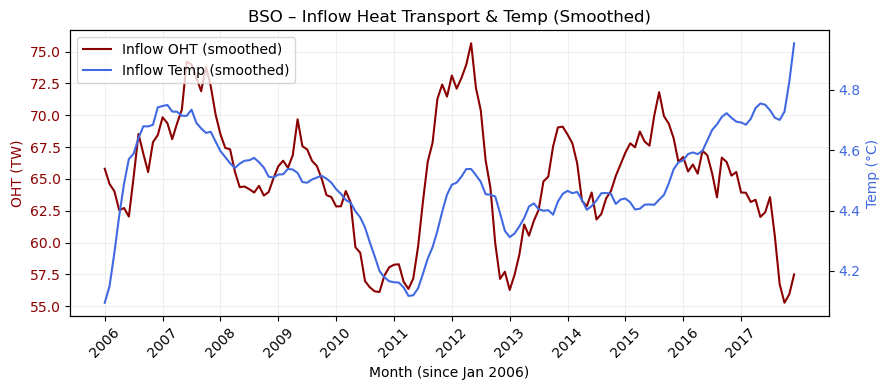

Processing SFJ...


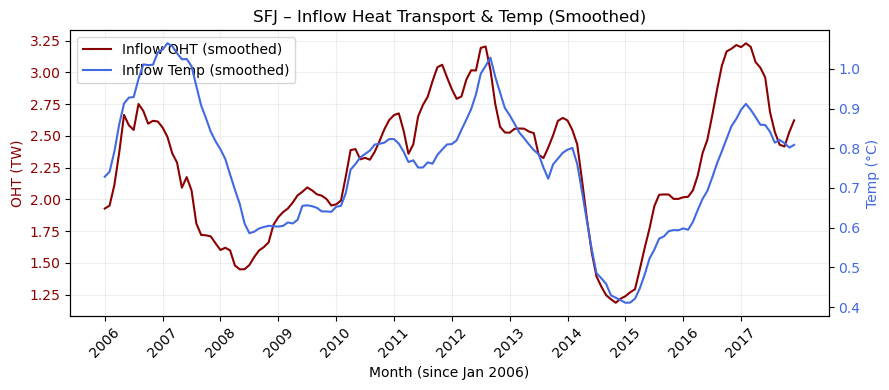

Processing FJNZ...


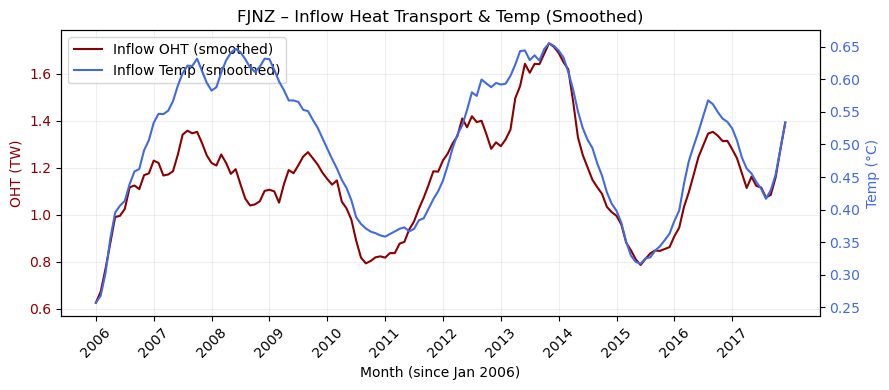

Processing NZRU...


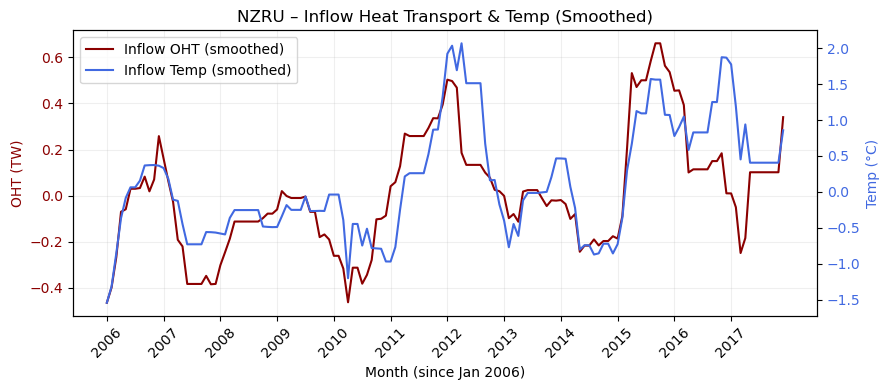

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
gates = ['BSO', 'SFJ', 'FJNZ', 'NZRU']
window_size = 12  # months
xtick_positions = np.arange(0, 12 * 12, 12)
xtick_labels = np.arange(2006, 2018)
time = np.arange(0, 12 * 12)

for gate in gates:
    print(f"Processing {gate}...")

    gate_slice = slice(0, len(gate_indices[gate][0]))  # full slice, or customize
    ysel = gate_indices[gate][0]
    xsel = gate_indices[gate][1]

    # Prepare area array
    area = np.zeros((nz, len(ysel)))
    for k in range(nz):
        for i in range(len(ysel)):
            y = ysel[i]
            x = xsel[i]
            if choose_UV_bso3d[k, y, x] == "H":
                area[k, i] = mygrid['DRF'][k] * mygrid['DYG'][y, x]
            else:  # assume 'V'
                area[k, i] = mygrid['DRF'][k] * mygrid['DXG'][y, x]

    # Load fields
    vel = vel_timeseries[gate][:, :, :, gate_slice]      # (time, year, z, x)
    theta = theta_timeseries[gate][:, :, :, gate_slice]

    # Grid metrics
    DRF = mygrid['DRF']                                   # (nz,)
    RAC_gate = mygrid['RAC'][gate_indices[gate]][gate_slice]  # (x,)

    # Volume array (same shape as theta)
    volume = np.zeros_like(theta)
    for k in range(nz):
        volume[:, :, k, :] = DRF[k] * RAC_gate[np.newaxis, :]

    # Inflow mask
    inflow_mask = vel > 0

    # Volume transport (m³/s)
    volume_in = np.nansum(vel * (vel > 0) * area[None,None,:,:], axis=(2, 3)) * 1e-6  # (time, year)

    # Volume-weighted temperature
    T_in = np.nansum(theta * inflow_mask, axis=(2, 3)) / \
           np.nansum(volume * inflow_mask, axis=(2, 3))              # (time, year)

    # Heat transport (TW)
    OHT_in = volume_in * T_in * myparms['rcp'] * 1e-6                # (time, year)

    # Smooth and flatten
    T_in_smooth = pd.Series(T_in.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()
    OHT_in_smooth = pd.Series(OHT_in.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()

    # Plot
    fig, ax1 = plt.subplots(figsize=(9, 4))
    ax1.plot(time, OHT_in_smooth, color="darkred", label="Inflow OHT (smoothed)")
    ax1.set_ylabel("OHT (TW)", color="darkred")
    ax1.tick_params(axis='y', labelcolor="darkred")
    ax1.set_title(f"{gate} – Inflow Heat Transport & Temp (Smoothed)")
    ax1.set_xticks(xtick_positions)
    ax1.set_xticklabels(xtick_labels, rotation=45)
    ax1.set_xlabel("Month (since Jan 2006)")
    ax1.grid(alpha=0.2)

    ax2 = ax1.twinx()
    ax2.plot(time, T_in_smooth, color="royalblue", label="Inflow Temp (smoothed)")
    ax2.set_ylabel("Temp (°C)", color="royalblue")
    ax2.tick_params(axis='y', labelcolor="royalblue")

    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    plt.tight_layout()
    plt.show()
